In [1]:
import sys
import os
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as opt
from torch.utils.data import Dataset, DataLoader, TensorDataset

from models.context_unet import ContextUnet
import ddpm.cu_ddpm as ddpm


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve

## Data
seq_len = 12
batch_size = 10
k = 15
customers = 64*64

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
cond_model = "mlp"
lr = 1e-4

## DDPM
timesteps = 500
beta_schedule = "linear"
objective = "pred_noise"
betas = [1e-4, 0.02]

model_name = "unet"
weights_dir = "../logging/unet_200epoch_all_customer_seq12/"

# Data

In [2]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [3]:
PREPROCESSED_DIR = "../preprocessing/data/customer_led_network_revolution/preprocessed/"

In [4]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))

train.drop("Date and Time of capture", axis=1, inplace=True)
test.drop("Date and Time of capture", axis=1, inplace=True)

In [5]:
col_row = int(np.sqrt(customers))

train = train.iloc[:, :customers]
test = test.iloc[:, :customers]

train_arr = np.asarray(train)
test_arr = np.asarray(test)

train_seq = np.asarray(MakeDATA(train_arr, seq_len))
test_seq = np.asarray(MakeDATA(test_arr, seq_len))

cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len))
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len))

img_train = train_seq.reshape(-1, seq_len, col_row, col_row)
img_test = test_seq.reshape(-1, seq_len, col_row, col_row)

train_dataset = TensorDataset(torch.from_numpy(img_train), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(img_test), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [6]:
model = ContextUnet(in_channels=seq_len, n_feat=col_row, n_cfeat=cond_train_seq.shape[2], height=col_row, cond_model=cond_model).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)
model.load_state_dict(torch.load(os.path.join(weights_dir, "weights/", "ep_20_mse_0.150_rmse_0.4713.pth"))["diffusion_state_dict"])

C:\Users\Arne\AppData\Local\Temp\ipykernel_22032\1194464593.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(weights_dir, "w

<All keys matched successfully>

In [ ]:
real_data_train = []
generated_data_train = []

for idx, (data, cond) in enumerate(train_loader):
    if idx == 3000:
        break
    
    if cond.shape[0] == data.shape[0] == batch_size:
        real_data_train.append(data.reshape(-1, seq_len, 64*64).permute(0, 2, 1))
        
        with torch.no_grad():
            sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size, context=cond.float().to(device), channels=seq_len, height=col_row, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
            sample = sample.cpu().numpy()
        
        generated_data_train.append(sample.reshape(-1, seq_len, 64*64).transpose(0, 2, 1))
    
generated_data = np.concatenate(real_data_train, axis=0)
real_data = np.concatenate(generated_data_train, axis=0)

generated_tensor = torch.tensor(generated_data, dtype=torch.float32)
real_tensor = torch.tensor(real_data, dtype=torch.float32)

generated_labels = torch.zeros(len(generated_tensor), dtype=torch.long)
real_labels = torch.ones(len(real_tensor), dtype=torch.long)

all_samples_train = torch.cat([generated_tensor, real_tensor], dim=0)
all_labels_train = torch.cat([generated_labels, real_labels], dim=0)

In [ ]:
real_data_test = []
generated_data_test = []

for idx, (data, cond) in enumerate(test_loader):
    if idx == 300:
        break
    
    if cond.shape[0] == data.shape[0] == batch_size:
        real_data_test.append(data.reshape(-1, seq_len, 64*64).permute(0, 2, 1))
        
        with torch.no_grad():
            samples, _ = ddpm.sample_ddpm_context(n_sample=batch_size, context=cond.float().to(device), channels=seq_len, height=col_row, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
            samples = samples.cpu().numpy()
        
        generated_data_test.append(samples.reshape(-1, seq_len, 64*64).transpose(0, 2, 1))
    
generated_data = np.concatenate(real_data_test, axis=0)
real_data = np.concatenate(generated_data_test, axis=0)

generated_tensor = torch.tensor(generated_data, dtype=torch.float32)
real_tensor = torch.tensor(real_data, dtype=torch.float32)

generated_labels = torch.zeros(len(generated_tensor), dtype=torch.long)
real_labels = torch.ones(len(real_tensor), dtype=torch.long)

all_samples_test = torch.cat([generated_tensor, real_tensor], dim=0)
all_labels_test = torch.cat([generated_labels, real_labels], dim=0)

In [9]:
class RealVsSyntheticDataset(Dataset):
    def __init__(self, samples, labels):
        self.samples = samples
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

In [10]:
dataset = RealVsSyntheticDataset(all_samples_train, all_labels_train)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

for x, y in train_loader:
    print(x.shape)  # (64, 15, 12)
    print(y.shape)  # (64,)
    break

torch.Size([64, 4096, 12])
torch.Size([64])


# Model

## Transformer

In [11]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=12, num_heads=2, hidden_dim=64, num_layers=2, seq_len=15):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim,
                                                   nhead=num_heads,
                                                   batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        # x: (batch, seq_len=15, input_dim=12)
        x = self.embedding(x) 
        x = self.transformer(x) 

        # Pool over the sequence dimension
        x = x.permute(0, 2, 1)  
        x = self.pool(x).squeeze(-1) 

        out = self.fc(x) 
        return out

In [12]:
model = TransformerClassifier()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = opt.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_accuracy = correct / total * 100

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.2f}%")

Epoch 1/10 - Loss: 0.0523 - Accuracy: 100.00%
Epoch 2/10 - Loss: 0.0012 - Accuracy: 100.00%
Epoch 3/10 - Loss: 0.0009 - Accuracy: 100.00%
Epoch 4/10 - Loss: 0.0008 - Accuracy: 100.00%
Epoch 5/10 - Loss: 0.0007 - Accuracy: 100.00%
Epoch 6/10 - Loss: 0.0007 - Accuracy: 100.00%
Epoch 7/10 - Loss: 0.0006 - Accuracy: 100.00%
Epoch 8/10 - Loss: 0.0006 - Accuracy: 100.00%
Epoch 9/10 - Loss: 0.0005 - Accuracy: 100.00%
Epoch 10/10 - Loss: 0.0005 - Accuracy: 100.00%


In [13]:
def evaluate(model, dataloader, device, plot=True):
    model.eval()
    correct = 0
    total = 0

    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # probability for "synthetic" class
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total * 100

    if plot:
        all_labels = torch.tensor(all_labels)
        all_preds = torch.tensor(all_preds)
        all_probs = torch.tensor(all_probs)

        # 1. Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Synthetic"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix")
        plt.show()

        # 2. ROC Curve
        fpr, tpr, _ = roc_curve(all_labels, all_probs)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 3. Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(all_labels, all_probs)
        plt.figure()
        plt.plot(recall, precision, label='PR Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.grid(True)
        plt.legend()
        plt.show()

    return f"Model Test Accuracy: {accuracy}"

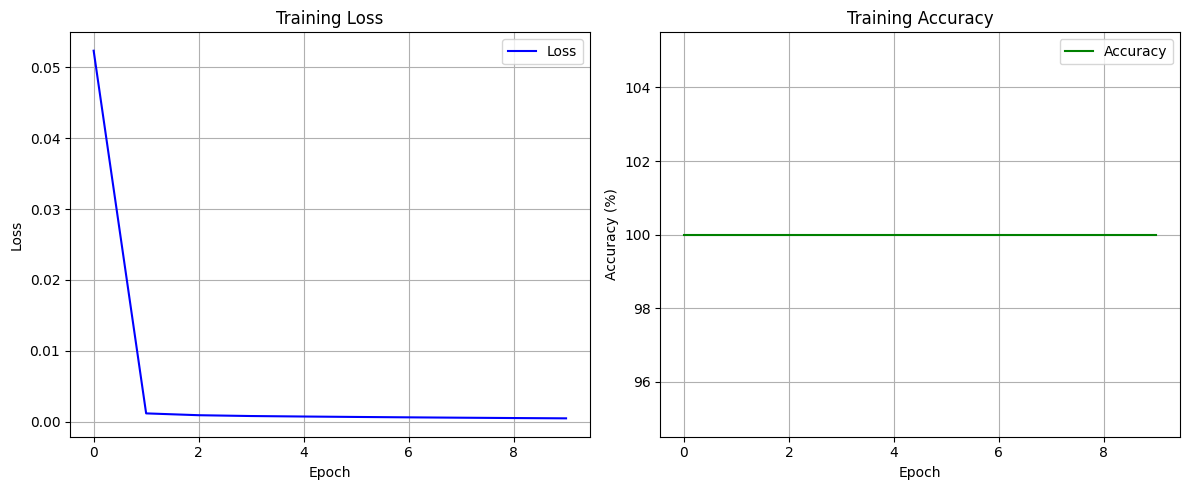

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Eval

In [15]:
dataset = RealVsSyntheticDataset(all_samples_test, all_labels_test)
test_loader = DataLoader(dataset, batch_size=64, shuffle=True)

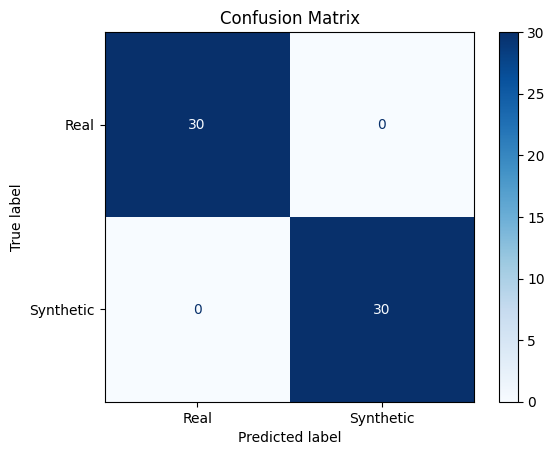

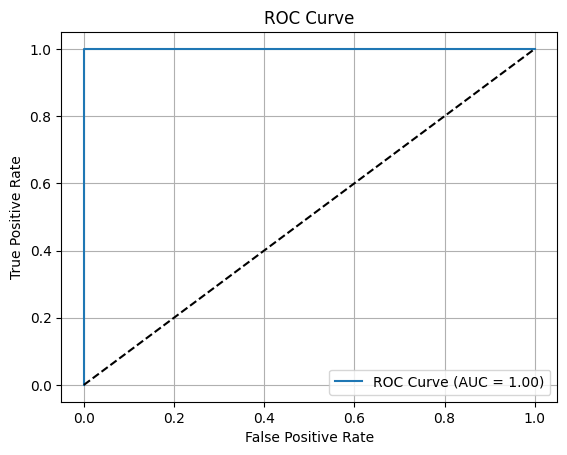

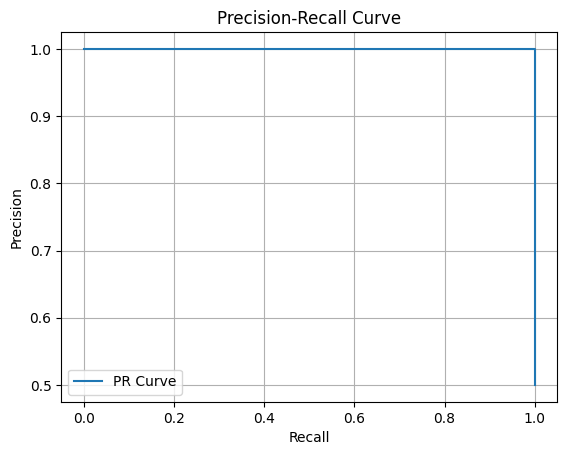

'Model Test Accuracy: 100.0'

In [16]:
evaluate(model, test_loader, device)